## Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

## Changing to relevant Directories
%cd '/content/drive/MyDrive/BD4h_project_draft/code/'
%pwd

Mounted at /content/drive
/content/drive/MyDrive/BD4h_project_draft/code


'/content/drive/MyDrive/BD4h_project_draft/code'

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import argparse
import os
import imp
import re
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import json

from readers import InHospitalMortalityReader, DecompensationReader, LengthOfStayReader, PhenotypingReader, MultitaskReader
from preprocessing import Discretizer, Normalizer
import common_utils

from model import SAnD
from trainer import NeuralNetworkClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Functions

In [3]:
def load_data(reader, discretizer, normalizer, return_names=False):
    N = reader.get_number_of_examples()
    ret = common_utils.read_chunk(reader, N)
    data = ret["X"]
    ts = ret["t"]
    labels = ret["y"]
    names = ret["name"]
    data = [discretizer.transform(X, end=t)[0] for (X, t) in zip(data, ts)]
    if normalizer is not None:
        data = [normalizer.transform(X) for X in data]
    whole_data = (np.array(data), labels)
    if not return_names:
        return whole_data
    return {"data": whole_data, "names": names}

def pad_zeros(arr, min_length=None):
    """
    `arr` is an array of `np.array`s

    The function appends zeros to every `np.array` in `arr`
    to equalize their first axis lenghts.
    """
    dtype = arr[0].dtype
    max_len = max([x.shape[0] for x in arr])
    ret = [np.concatenate([x, np.zeros((max_len - x.shape[0],) + x.shape[1:], dtype=dtype)], axis=0)
           for x in arr]
    if (min_length is not None) and ret[0].shape[0] < min_length:
        ret = [np.concatenate([x, np.zeros((min_length - x.shape[0],) + x.shape[1:], dtype=dtype)], axis=0)
               for x in ret]
    return np.array(ret)

def load_data_decomp(reader, discretizer, normalizer,
                     small = False,
                     return_names=False):
    N = reader.get_number_of_examples()
    if small:
      N = 5000
    ret = common_utils.read_chunk(reader, N)
    ret.keys()

    data = ret["X"]
    ts = ret["t"]
    labels = ret["y"]
    names = ret["name"]
    data = [discretizer.transform(X, end=t)[0] for (X, t) in zip(data, ts)]
    if normalizer is not None:
        data = [normalizer.transform(X) for X in data]
    data = pad_zeros(data, min_length = 1044)
    whole_data = (np.array(data), labels)
    if not return_names:
        return whole_data
    return {"data": whole_data, "names": names, 'base_data':ret['X'], 'base_y':ret["y"]}

class CustomBins:
    inf = 1e18
    bins = [(-inf, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 14), (14, +inf)]
    nbins = len(bins)
    means = [11.450379, 35.070846, 59.206531, 83.382723, 107.487817,
             131.579534, 155.643957, 179.660558, 254.306624, 585.325890]


def get_bin_custom(x, nbins, one_hot=False):
    for i in range(nbins):
        a = CustomBins.bins[i][0] * 24.0
        b = CustomBins.bins[i][1] * 24.0
        if a <= x < b:
            if one_hot:
                ret = np.zeros((CustomBins.nbins,))
                ret[i] = 1
                return ret
            return i
    return None


def load_data_stay(reader, discretizer, normalizer,
                   small_part=False,
                   return_names=False):
    N = reader.get_number_of_examples()
    if small_part:
        N = 150
    ret = common_utils.read_chunk(reader, N)

    data = ret["X"]
    ts = ret["t"]
    labels = ret["y"]
    labels = [get_bin_custom(x, CustomBins.nbins) for x in labels]
    labels = np.array(labels)

    names = ret["name"]
    data = [discretizer.transform(X, end=t)[0] for (X, t) in zip(data, ts)]
    if normalizer is not None:
        data = [normalizer.transform(X) for X in data]
    data = pad_zeros(data, min_length = 1062)
    whole_data = (np.array(data), labels)
    if not return_names:
        return whole_data
    return {"data": whole_data, "names": names}

def load_data_phenotype(reader, discretizer, normalizer,
                        small_part=False,
                        return_names=False):
    N = reader.get_number_of_examples()
    if small_part:
         N = 500
    ret = common_utils.read_chunk(reader, N)

    data = ret["X"]
    ts = ret["t"]
    labels = ret["y"]
    labels = np.array(labels)

    names = ret["name"]
    data = [discretizer.transform(X, end=t)[0] for (X, t) in zip(data, ts)]
    if normalizer is not None:
        data = [normalizer.transform(X) for X in data]
    data = pad_zeros(data, min_length = 1063)
    whole_data = (np.array(data), labels)
    if not return_names:
        return whole_data
    return {"data": whole_data, "names": names}

file_path = '/content/drive/MyDrive/BD4h_project_draft/code/'


## In Hospital Mortality

In [5]:
# train_reader = InHospitalMortalityReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/in-hospital-mortality/', 'train'),
#                                          listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/in-hospital-mortality/', 'train_listfile.csv'),
#                                          period_length=24.0)

# val_reader = InHospitalMortalityReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/in-hospital-mortality/', 'train'),
#                                        listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/in-hospital-mortality/', 'val_listfile.csv'),
#                                        period_length=24.0)

# test_reader = InHospitalMortalityReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/in-hospital-mortality/', 'test'),
#                                          listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/in-hospital-mortality/', 'test_listfile.csv'),
#                                          period_length=24.0)

# discretizer = Discretizer(store_masks=True,
#                           impute_strategy='previous',
#                           start_time='zero')

# discretizer_header = discretizer.transform(train_reader.read_example(0)["X"])[1].split(',')
# cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]

# normalizer = Normalizer(fields=cont_channels)  # choose here which columns to standardize
# normalizer_state = None
# if normalizer_state is None:
#     normalizer_state = 'ihm_ts{}.input_str-{}.start_time-zero.normalizer'.format('0.8', 'previous')
#     normalizer_state = os.path.join(os.path.dirname(file_path), normalizer_state)
# normalizer.load_params(normalizer_state)
# train_raw = load_data(train_reader, discretizer, normalizer)
# val_raw = load_data(val_reader, discretizer, normalizer)
# test_raw = load_data(test_reader, discretizer, normalizer)

# x_train = torch.Tensor(train_raw[0]).float()   # [N, seq_len, features]
# x_val = torch.Tensor(val_raw[0]).float()
# x_test = torch.Tensor(test_raw[0]).float()
# y_train = torch.Tensor(train_raw[1]).long()
# y_val = torch.Tensor(val_raw[1]).long()
# y_test = torch.Tensor(test_raw[1]).long()
# print(x_train.shape)
# print(x_val.shape)
# print(x_test.shape)
# print(y_train.shape)
# train_ds = TensorDataset(x_train, y_train)
# val_ds = TensorDataset(x_val, y_val)
# test_ds = TensorDataset(x_test, y_test)
# train_loader = DataLoader(train_ds, batch_size=256)
# val_loader = DataLoader(val_ds, batch_size=256)
# test_loader = DataLoader(test_ds, batch_size=256)

# Loading data and running model

train_loader = torch.load('/content/drive/MyDrive/BD4h_project_draft/data/in-hospital-mortality/train_dataset_ihm.pth')
val_loader = torch.load('/content/drive/MyDrive/BD4h_project_draft/data/in-hospital-mortality/val_dataset_ihm.pth')
test_loader = torch.load('/content/drive/MyDrive/BD4h_project_draft/data/in-hospital-mortality/test_dataset_ihm.pth')

in_feature = 76
seq_len = 30
n_heads = 8
factor = 12
num_class = 2
num_layers = 4

clf = NeuralNetworkClassifier(
    SAnD(in_feature, seq_len, n_heads, factor,
         num_class, num_layers, d_model=24 ,dropout_rate = 0.3),
    nn.CrossEntropyLoss(),
    optim.Adam, optimizer_config={"lr": 5e-4,
                                  "betas": (0.9, 0.98),
                                  "eps": 10e-08,
                                  "weight_decay": 1e-20}
)

# training network

results_dict_ihm = clf.fit(
    {"train": train_loader,
     "val": val_loader},
    epochs=20,
    validation = True
)
## Saving Model
in_hospital_saved_file = clf.save_to_file('/content/drive/MyDrive/BD4h_project_draft/models/IHM/')

## Saving Results Jsons


with open('/content/drive/MyDrive/BD4h_project_draft/models/IHM/ihm_results.json', 'w') as fp:
    json.dump(results_dict_ihm, fp)
## evaluating
clf.evaluate(test_loader, LOS = False)


Training - Epochs: 020/020: 100%|██████████| 14681/14681 [00:06<00:00, 2266.97it/s]


train accuracy and loss per epoch:  [{0: 0.813636673251141, 1: 0.8605680811933792, 2: 0.8590695456712758, 3: 0.860159389687351, 4: 0.8609767726994074, 5: 0.8626115387235201, 6: 0.8641100742456236, 7: 0.8672433757918397, 8: 0.866289762277774, 9: 0.8666984537838022, 10: 0.8679926435528915, 11: 0.8692868333219808, 12: 0.8688100265649479, 13: 0.8706491383420748, 14: 0.8721476738641782, 15: 0.8694230638239901, 16: 0.8690824875689667, 17: 0.8726925958722158, 18: 0.8733737483822628, 19: 0.8729650568762346}, {0: 0.3963742256164551, 1: 0.3526034653186798, 2: 0.3570935130119324, 3: 0.33882665634155273, 4: 0.32187724113464355, 5: 0.3393542766571045, 6: 0.3473811447620392, 7: 0.3544991612434387, 8: 0.34767448902130127, 9: 0.3050307035446167, 10: 0.3388306796550751, 11: 0.3427050709724426, 12: 0.3363850712776184, 13: 0.3171041011810303, 14: 0.328253835439682, 15: 0.32336458563804626, 16: 0.32610538601875305, 17: 0.30900463461875916, 18: 0.2863869071006775, 19: 0.3110835552215576}]
validation accura

Evaluating: 100%|██████████| 3236/3236 [00:00<00:00, 5150.15it/s]

Evaluation finished. Accuracy: 0.8847
All Metrics:  {'auroc': 0.5361615282059881, 'auprc': 0.33721281888180304, 'minpse': 0.12434268252248173}


(0.884734239802225,
 {'auroc': 0.5361615282059881,
  'auprc': 0.33721281888180304,
  'minpse': 0.12434268252248173})

### PLOT

In [18]:
epochs = list(results_dict_ihm['train'][0].keys())
train_acc = list(results_dict_ihm['train'][0].values())
val_acc = list(results_dict_ihm['val'][0].values())
train_loss = list(results_dict_ihm['train'][1].values())
val_loss = list(results_dict_ihm['val'][1].values())

In [15]:
train_acc

[0.813636673251141,
 0.8605680811933792,
 0.8590695456712758,
 0.860159389687351,
 0.8609767726994074,
 0.8626115387235201,
 0.8641100742456236,
 0.8672433757918397,
 0.866289762277774,
 0.8666984537838022,
 0.8679926435528915,
 0.8692868333219808,
 0.8688100265649479,
 0.8706491383420748,
 0.8721476738641782,
 0.8694230638239901,
 0.8690824875689667,
 0.8726925958722158,
 0.8733737483822628,
 0.8729650568762346]

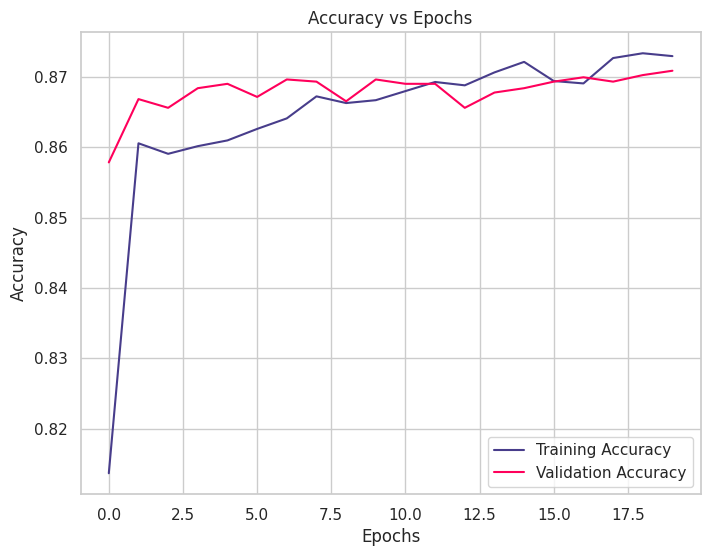

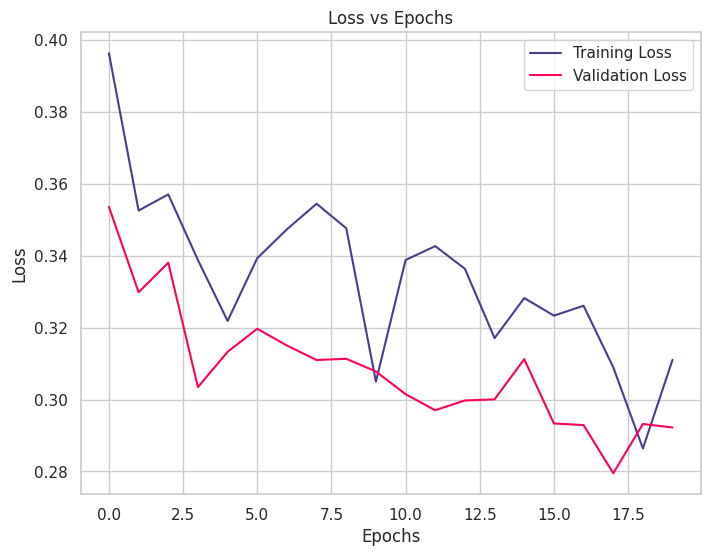

In [22]:
color_palette = ['darkslateblue', '#FF005B']
sns.set_theme(style='whitegrid')
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color=color_palette[0])
plt.plot(epochs, val_acc, label='Validation Accuracy', color=color_palette[1])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss', color=color_palette[0])
plt.plot(epochs, val_loss, label='Validation Loss', color=color_palette[1])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
clf.fit(
    {"train": train_loader,
     "val": val_loader},
    epochs=10,
    validation = True
)

# reloading the and evaluate with loaded models make sure to change the path
clf.restore_from_file('/content/drive/MyDrive/BD4h_project_draft/models/IHM/model_params-epochs_1-Mon_Apr_15_22:45:20_2024.pth')

with open('/content/drive/MyDrive/BD4h_project_draft/models/IHM/ihm_results.json', 'r') as fp:
    results_dict_ihm = json.load(fp)

clf.evaluate(test_loader, LOS = False)

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 370.84it/s]

Evaluation finished. Accuracy: 0.5455
All Metrics:  {'auroc': 0.55, 'auprc': 0.6409090909090909, 'minpse': 0.5}


In [ ]:
results_dict_ihm

{'train': [{'0': 0.5365853658536586}, {'0': 1.4313393831253052}],
 'val': [{'0': 0.6}, {'0': 1.7555068731307983}]}

## Decompensation

In [4]:
# train_reader = DecompensationReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/', 'train'),
#                                         listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/', 'train_listfile.csv'))
# val_reader = DecompensationReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/', 'train'),
#                                   listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/', 'val_listfile.csv'))

# test_reader = DecompensationReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/', 'test'),
#                                   listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/', 'test_listfile.csv'))

# discretizer = Discretizer(store_masks=True,
#                           impute_strategy='previous',
#                           start_time='zero')


# discretizer_header = discretizer.transform(train_reader.read_example(0)["X"])[1].split(',')
# cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]

# normalizer = Normalizer(fields=cont_channels)  # choose here which columns to standardize
# normalizer_state = None
# if normalizer_state is None:
#     normalizer_state = 'decomp_ts{}.input_str-previous.n1e5.start_time-zero.normalizer'.format(0.8)
#     normalizer_state = os.path.join(os.path.dirname(file_path), normalizer_state)
# normalizer.load_params(normalizer_state)
# train_raw = load_data_decomp(train_reader, discretizer, normalizer, small = False)
# valid_raw = load_data_decomp(val_reader, discretizer, normalizer, small = False)
# test_raw = load_data_decomp(test_reader, discretizer, normalizer, small= False)
# x_train = torch.Tensor(train_raw[0]).float()
# x_val = torch.Tensor(valid_raw[0]).float()
# x_test = torch.Tensor(test_raw[0]).float()


# y_train = torch.Tensor(train_raw[1]).long()
# y_val = torch.Tensor(valid_raw[1]).long()
# y_test = torch.Tensor(test_raw[1]).long()
# print(x_train.shape)
# print(x_val.shape)
# print(x_test.shape)
# print(y_train.shape)
# train_ds = TensorDataset(x_train, y_train)
# val_ds = TensorDataset(x_val, y_val)
# test_ds = TensorDataset(x_test, y_test)

# train_loader = DataLoader(train_ds, batch_size=128, shuffle = True)
# val_loader = DataLoader(val_ds, batch_size=128, shuffle = True)
# test_loader = DataLoader(test_ds, batch_size=128, shuffle = True)

# torch.save(train_loader, '/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/train_dataset_decp.pth')
# torch.save(test_loader, '/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/test_dataset_decp.pth')
# torch.save(val_loader, '/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/val_dataset_decp.pth')


train_loader = torch.load('/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/train_dataset_decp.pth')
val_loader = torch.load('/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/val_dataset_decp.pth')
# test_loader = torch.load('/content/drive/MyDrive/BD4h_project_draft/data/decompensation_demo/test_dataset_decp.pth')


in_feature = 76
seq_len = 1044
n_heads = 8
factor = 10
num_class = 2
num_layers = 1

clf = NeuralNetworkClassifier(
    SAnD(in_feature, seq_len, n_heads, factor,
         num_class, num_layers, d_model=24 ,dropout_rate = 0.3),
    nn.CrossEntropyLoss(),
    optim.Adam, optimizer_config={"lr": 1e-3,
                                  "betas": (0.9, 0.98),
                                  "eps": 10e-08,
                                  "weight_decay": 1e-20}
)

# # training network
# clf.fit(
#     {"train": train_loader,
#      "val": val_loader},
#     epochs=1,
#     validation = True
# )
# # evaluating
# clf.evaluate(test_loader, LOS = False)

results_dict_decomp = clf.fit(
    {"train": train_loader,
     "val": val_loader},
    epochs=20,
    validation = True
)
## Saving Model
decom_saved_file = clf.save_to_file('/content/drive/MyDrive/BD4h_project_draft/models/Decompensation/')

## Saving Results Jsons


with open('/content/drive/MyDrive/BD4h_project_draft/models/Decompensation/decomp_results.json', 'w') as fp:
    json.dump(results_dict_decomp, fp)
## evaluating
# clf.evaluate(test_loader, LOS = False)


Training - Epochs: 020/020: 100%|██████████| 8236/8236 [18:09<00:00,  7.56it/s]


train accuracy and loss per epoch:  [{0: 0.930791646430306, 1: 0.9447547353084021, 2: 0.9405050995628946, 3: 0.9463331714424478, 4: 0.9522826614861584, 5: 0.9510684798445848, 6: 0.9545896066051481, 7: 0.9629674599320058, 8: 0.9640602234094221, 9: 0.968431277319087, 10: 0.9698882952889752, 11: 0.9655172413793104, 12: 0.9788732394366197, 13: 0.9707382224380767, 14: 0.9843370568237009, 15: 0.9770519669742593, 16: 0.9815444390480816, 17: 0.9851869839728024, 18: 0.985065565808645, 19: 0.9881010199125789}, {0: 5.562723159790039, 1: 5.012153110328654e-07, 2: 3.1705024242401123, 3: 0.459616094827652, 4: 1.2279949188232422, 5: 0.5350232124328613, 6: 0.029048847034573555, 7: 0.03869565203785896, 8: 0.05859949439764023, 9: 0.5126383304595947, 10: 0.3274877965450287, 11: 0.6506381630897522, 12: 0.6507666110992432, 13: 0.0, 14: 3.7930206531200383e-08, 15: 0.8397899866104126, 16: 0.3492320477962494, 17: 6.773245786462212e-08, 18: 1.770922426658217e-05, 19: 0.0003891073283739388}]
validation accuracy

## Length of Stay


In [4]:
train_reader = LengthOfStayReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/length-of-stay_demo/', 'train'),
                                      listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/length-of-stay_demo/', 'train_listfile.csv'))
val_reader = LengthOfStayReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/length-of-stay_demo/', 'train'),
                                    listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/length-of-stay_demo/', 'val_listfile.csv'))

test_reader = LengthOfStayReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/length-of-stay_demo/', 'test'),
                                  listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/length-of-stay_demo/', 'test_listfile.csv'))


discretizer = Discretizer(store_masks=True,
                          impute_strategy='previous',
                          start_time='zero')
discretizer_header = discretizer.transform(train_reader.read_example(0)["X"])[1].split(',')

cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]

normalizer = Normalizer(fields=cont_channels)
normalizer_state = None
if normalizer_state is None:
    normalizer_state = 'los_ts{}.input_str-previous.start_time-zero.n5e4.normalizer'.format(0.8)
    normalizer_state = os.path.join(os.path.dirname(file_path), normalizer_state)
normalizer.load_params(normalizer_state)
train_raw = load_data_stay(train_reader, discretizer, normalizer, small_part = True)
valid_raw = load_data_stay(val_reader, discretizer, normalizer, small_part = True)
test_raw = load_data_stay(test_reader, discretizer, normalizer, small_part = True)
x_train = torch.Tensor(train_raw[0]).float()
x_val = torch.Tensor(valid_raw[0]).float()
x_test = torch.Tensor(test_raw[0]).float()
y_train = torch.Tensor(train_raw[1]).long()
y_val = torch.Tensor(valid_raw[1]).long()
y_test = torch.Tensor(test_raw[1]).long()
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_ds, batch_size=256, shuffle = True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle = True)

torch.save(train_loader, '/content/drive/MyDrive/BD4h_project_draft/data/length-of-stay_demo/train_dataset_los.pth')
torch.save(test_loader, '/content/drive/MyDrive/BD4h_project_draft/data/length-of-stay_demo/test_dataset_los.pth')
torch.save(val_loader, '/content/drive/MyDrive/BD4h_project_draft/data/length-of-stay_demo/val_dataset_los.pth')

# in_feature = 76
# seq_len = 1060
# n_heads = 1
# factor = 2
# num_class = 10
# num_layers = 1

# clf = NeuralNetworkClassifier(
#     SAnD(in_feature, seq_len, n_heads, factor, num_class, num_layers),
#     nn.CrossEntropyLoss(),
#     optim.Adam, optimizer_config={"lr": 1e-5,
#                                   "betas": (0.9, 0.98),
#                                   "eps": 4e-09,
#                                   "weight_decay": 5e-4}
# )

# # training network
# clf.fit(
#     {"train": train_loader,
#      "val": val_loader},
#     epochs=1
# )
# clf.evaluate(test_loader, LOS = True)



torch.Size([150, 1062, 76])
torch.Size([150, 1062, 76])
torch.Size([150, 1062, 76])
torch.Size([150])


In [5]:
# train_loader = torch.load('/content/drive/MyDrive/BD4h_project_draft/data/length-of-stay_demo/train_dataset_los.pth')
# val_loader = torch.load('/content/drive/MyDrive/BD4h_project_draft/data/length-of-stay_demo/val_dataset_los.pth')
in_feature = 76
seq_len = 1062
n_heads = 8
factor = 12
num_class = 10
num_layers = 3

clf = NeuralNetworkClassifier(
    SAnD(in_feature, seq_len, n_heads, factor,
         num_class, num_layers, d_model=24 ,dropout_rate = 0.3),
    nn.CrossEntropyLoss(),
    optim.Adam, optimizer_config={"lr": 1e-3,
                                  "betas": (0.9, 0.98),
                                  "eps": 10e-08,
                                  "weight_decay": 1e-20}
)

# # training network
# clf.fit(
#     {"train": train_loader,
#      "val": val_loader},
#     epochs=1,
#     validation = True
# )
# # evaluating
# clf.evaluate(test_loader, LOS = False)

results_dict_los = clf.fit(
    {"train": train_loader,
     "val": val_loader},
    epochs=20,
    validation = True
)
## Saving Model
decom_saved_file = clf.save_to_file('/content/drive/MyDrive/BD4h_project_draft/models/LOS/')

## Saving Results Jsons


with open('/content/drive/MyDrive/BD4h_project_draft/models/LOS/los_results.json', 'w') as fp:
    json.dump(results_dict_los, fp)

Training - Epochs: 020/020: 100%|██████████| 150/150 [00:41<00:00,  3.57it/s]


train accuracy and loss per epoch:  [{0: 0.21333333333333335, 1: 0.14, 2: 0.15333333333333332, 3: 0.07333333333333333, 4: 0.24, 5: 0.06666666666666667, 6: 0.14, 7: 0.06666666666666667, 8: 0.05333333333333334, 9: 0.12, 10: 0.23333333333333334, 11: 0.24, 12: 0.25333333333333335, 13: 0.2, 14: 0.13333333333333333, 15: 0.21333333333333335, 16: 0.21333333333333335, 17: 0.18, 18: 0.17333333333333334, 19: 0.19333333333333333}, {0: 252.66099548339844, 1: 247.6807861328125, 2: 138.51821899414062, 3: 101.33756256103516, 4: 124.04956817626953, 5: 169.36488342285156, 6: 189.50100708007812, 7: 184.93280029296875, 8: 181.70802307128906, 9: 116.92283630371094, 10: 103.4239730834961, 11: 112.86829376220703, 12: 110.65182495117188, 13: 99.01045989990234, 14: 93.52467346191406, 15: 92.69514465332031, 16: 81.32032775878906, 17: 88.42371368408203, 18: 88.34977722167969, 19: 74.89539337158203}]
validation accuracy and loss per epoch:  [{0: 0.18, 1: 0.16, 2: 0.1, 3: 0.0, 4: 0.006666666666666667, 5: 0.08, 6: 

## Phenotyping


In [9]:
train_reader = PhenotypingReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/phenotyping_demo/', 'train'),
                                      listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/phenotyping_demo/', 'train_listfile.csv'))
val_reader = PhenotypingReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/phenotyping_demo/', 'train'),
                                    listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/phenotyping_demo/', 'val_listfile.csv'))

test_reader = PhenotypingReader(dataset_dir=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/phenotyping_demo/', 'test'),
                                  listfile=os.path.join('/content/drive/MyDrive/BD4h_project_draft/data/phenotyping_demo/', 'test_listfile.csv'))

discretizer = Discretizer(store_masks=True,
                          impute_strategy='previous',
                          start_time='zero')
discretizer_header = discretizer.transform(train_reader.read_example(0)["X"])[1].split(',')

cont_channels = [i for (i, x) in enumerate(discretizer_header) if x.find("->") == -1]

normalizer = Normalizer(fields=cont_channels)
normalizer_state = None
if normalizer_state is None:
    normalizer_state = 'ph_ts{}.input_str-previous.start_time-zero.normalizer'.format(0.8)
    normalizer_state = os.path.join(os.path.dirname(file_path), normalizer_state)
normalizer.load_params(normalizer_state)

train_raw = load_data_phenotype(train_reader, discretizer, normalizer, small_part=True)
valid_raw = load_data_phenotype(val_reader, discretizer, normalizer, small_part=True)
test_raw = load_data_phenotype(test_reader, discretizer, normalizer, small_part=True)
x_train = torch.Tensor(train_raw[0]).float()
x_val = torch.Tensor(valid_raw[0]).float()
x_test = torch.Tensor(test_raw[0]).float()


y_train = torch.Tensor(train_raw[1]).float()
y_val = torch.Tensor(valid_raw[1]).float()
y_test = torch.Tensor(test_raw[1]).float()
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
train_ds = TensorDataset(x_train, y_train)
val_ds = TensorDataset(x_val, y_val)
test_ds = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle = True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle = True)

torch.save(train_loader, '/content/drive/MyDrive/BD4h_project_draft/data/phenotyping_demo/train_dataset_pheno.pth')
torch.save(test_loader, '/content/drive/MyDrive/BD4h_project_draft/data/phenotyping_demo/test_dataset_pheno.pth')
torch.save(val_loader, '/content/drive/MyDrive/BD4h_project_draft/data/phenotyping_demo/val_dataset_pheno.pth')

# in_feature = 76
# seq_len = 1063
# n_heads = 1
# factor = 2
# num_class = 25
# num_layers = 1

# clf = NeuralNetworkClassifier(
#     SAnD(in_feature, seq_len, n_heads, factor, num_class, num_layers),
#     nn.CrossEntropyLoss(),
#     optim.Adam,
#     optimizer_config={"lr": 51e-5,
#                                   "betas": (0.9, 0.98),
#                                   "eps": 4e-09,
#                                   "weight_decay": 5e-4}
# )

# # training network
# clf.fit_phenotype(
#     {"train": train_loader,
#      "val": val_loader},
#     epochs=1
# )

# clf.evaluate_phenotype(test_loader)


torch.Size([500, 1063, 76])
torch.Size([500, 1063, 76])
torch.Size([500, 1063, 76])
torch.Size([500, 25])


In [5]:
train_loader = torch.load('/content/drive/MyDrive/BD4h_project_draft/data/phenotyping_demo/train_dataset_pheno.pth')
val_loader = torch.load('/content/drive/MyDrive/BD4h_project_draft/data/phenotyping_demo/val_dataset_pheno.pth')
in_feature = 76
seq_len = 1063
n_heads = 8
factor = 120
num_class = 25
num_layers = 2

clf = NeuralNetworkClassifier(
    SAnD(in_feature, seq_len, n_heads, factor,
         num_class, num_layers, d_model=96 ,dropout_rate = 0.4),
    nn.CrossEntropyLoss(),
    optim.Adam, optimizer_config={"lr": 5e-4,
                                  "betas": (0.9, 0.98),
                                  "eps": 10e-08,
                                  "weight_decay": 1e-20}
)

# # training network
# clf.fit(
#     {"train": train_loader,
#      "val": val_loader},
#     epochs=1,
#     validation = True
# )
# # evaluating
# clf.evaluate(test_loader, LOS = False)

results_dict_ph = clf.fit_phenotype(
    {"train": train_loader,
     "val": val_loader},
    epochs=20,
    validation = True
)
## Saving Model
phen_saved_file = clf.save_to_file('/content/drive/MyDrive/BD4h_project_draft/models/Phenotyping/')

## Saving Results Jsons


with open('/content/drive/MyDrive/BD4h_project_draft/models/Phenotyping/ph_results.json', 'w') as fp:
    json.dump(results_dict_ph, fp)


Training - Epochs: 001/020: 100%|██████████| 500/500 [01:35<00:00,  5.25it/s]

Training - Epochs: 002/020: 100%|██████████| 500/500 [01:36<00:00,  5.20it/s]

Training - Epochs: 003/020: 100%|██████████| 500/500 [01:40<00:00,  4.97it/s]

Training - Epochs: 004/020: 100%|██████████| 500/500 [01:41<00:00,  4.91it/s]

Training - Epochs: 005/020: 100%|██████████| 500/500 [01:35<00:00,  5.25it/s]

Training - Epochs: 006/020: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]

Training - Epochs: 007/020: 100%|██████████| 500/500 [01:40<00:00,  4.96it/s]

Training - Epochs: 008/020: 100%|██████████| 500/500 [01:39<00:00,  5.02it/s]

Training - Epochs: 009/020: 100%|██████████| 500/500 [01:39<00:00,  5.01it/s]

Training - Epochs: 010/020: 100%|██████████| 500/500 [01:35<00:00,  5.23it/s]

Training - Epochs: 011/020: 100%|██████████| 500/500 [01:35<00:00,  5.25it/s]

Training - Epochs: 012/020: 100%|██████████| 500/500 [01:35<00:00,  5.22it/s]

Training - Epochs: 013/020: 100%|██████████| 500/50

train accuracy and loss per epoch:  [{0: 0.30693965777754784, 1: 0.23879579454660416, 2: 0.2632812485098839, 3: 0.36520473659038544, 4: 0.5836341679096222, 5: 0.4759886860847473, 6: 0.5272683203220367, 7: 0.4649111032485962, 8: 0.4713362157344818, 9: 0.4363846927881241, 10: 0.3861961215734482, 11: 0.3851185366511345, 12: 0.3893507570028305, 13: 0.3801104500889778, 14: 0.4011799544095993, 15: 0.3666864261031151, 16: 0.30991918593645096, 17: 0.3042941763997078, 18: 0.3058324381709099, 19: 0.3207327499985695}, {0: 12213.591064453125, 1: 19822.9794921875, 2: 25135.2998046875, 3: 14053.580322265625, 4: 10281.28125, 5: 7462.8284912109375, 6: 6953.8328857421875, 7: 4381.906555175781, 8: 4120.4339599609375, 9: 3323.0599975585938, 10: 2834.3958740234375, 11: 2956.7567138671875, 12: 2867.2664794921875, 13: 3484.487060546875, 14: 4367.2376708984375, 15: 4079.9981079101562, 16: 3907.1031494140625, 17: 3264.3851928710938, 18: 2658.9706420898438, 19: 2280.0032958984375}]
validation accuracy and loss